In [119]:
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

### Calibrate Transition matrix

$\epsilon_1 = 1$ employed  
$\epsilon_2 = 0$ unemployed  
$\pi_{ij} = \{\epsilon' = \epsilon_j | \epsilon = \epsilon_i\}$  

- $\pi_{11} = 0.9$, $\pi_{12} = 0.1$
- $u = 0.05$
- assume $\pi_{22} = x$

$$u * \pi_{22} + (1-u) * \pi_{12} = u$$
$$0.1 * x + 0.9 * 0.1 = 0.1$$
$$0.1 * x + 0.09 = 0.1$$
$$0.1 * x = 0.01$$
$$x = 0.1$$

Hence the transition matrix is
$$\left[
\begin{matrix}
0.9 & 0.1 \\
0.9 & 0.1 \\
\end{matrix}
\right]$$

### Solve for steady state

In [55]:
def get_r(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    r = α * np.sign(k) * np.abs(k)**(α - 1) * (1 - u)**(1 - α)
    
    return r

def get_w(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    w = (1 - α) * np.sign(k) * np.abs(k)**α * (1 - u)**(-α)
    
    return w

def get_c(w, r, k, kp, ϵ, *params):
    
    # unpack params:
    α, β, δ, u = params
    
    c = r + w*ϵ + (1 - δ)*k - kp
    
    return c

def get_mu(c):
    
    mu = 1/c
    
    return mu

def Euler(k, *params):
    
    # unpack params:
    α, β, δ, u = params
    u = 0.1 # representative agent has no unemployment probability
    ϵ = 1
    # get variables
    r = get_r(k, *params)
    w = get_w(k, *params)
    c = get_c(w, r, k, k, ϵ, *params)
    mu = get_mu(c)
    
    # Euler
    f1 = -1 * mu + β * (r + 1 - δ) * mu
    
    return f1

def solve_SS(*params):
    
    # unpack params:
    α, β, δ, u = params
    kbar = float(opt.fsolve(Euler, 6, args = params))
    rbar = get_r(kbar, *params)
    
    return kbar, rbar

def params1():
    
    α = 0.36
    β = 0.96
    δ = 0.06
    u = 0.1
    
    params = α, β, δ, u
    
    return params

kbar, rbar = solve_SS(*params1())
print(kbar, rbar)

6.490058753339534 0.10166666666666702


### Iterate on Bellman equation to find $\nu(k, \epsilon; \bar{k})$

[[-2.28664613e+00 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05]
 [ 3.40008854e-01 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05]]
[[-2.28664613e+00 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05]
 [ 3.40008854e-01 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05]]
[[-2.28664613e+00 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05]
 [ 3.40008854e-01 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+05 -9.99999000e+05 -9.99999000e+05
  -9.99999000e+05 -9.99999000e+

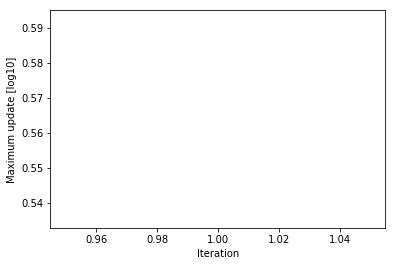

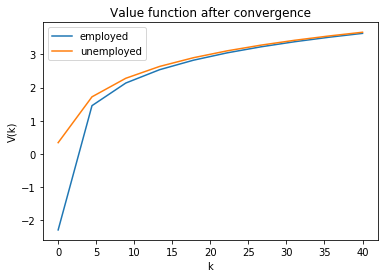

[[-4.22966753e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06]
 [-1.60301255e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06]]
[[-4.22966753e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06]
 [-1.60301255e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06]]
[[-4.22966753e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06]
 [-1.60301255e+00 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+06 -1.00000094e+06 -1.00000094e+06
  -1.00000094e+06 -1.00000094e+

  -9.99980080e+05 -9.99980080e+05]]
[[ 2.17425043e+01  2.14355033e+01  2.09902434e+01  2.01672246e+01
  -9.99980080e+05 -9.99980080e+05 -9.99980080e+05 -9.99980080e+05
  -9.99980080e+05 -9.99980080e+05]
 [ 2.18171699e+01  2.15356937e+01  2.11425260e+01  2.04853890e+01
   1.78366305e+01 -9.99980080e+05 -9.99980080e+05 -9.99980080e+05
  -9.99980080e+05 -9.99980080e+05]]
[[ 2.34387898e+01  2.32008676e+01  2.28880584e+01  2.24303617e+01
   2.15618380e+01 -9.99978605e+05 -9.99978605e+05 -9.99978605e+05
  -9.99978605e+05 -9.99978605e+05]
 [ 2.34990324e+01  2.32766921e+01  2.29903474e+01  2.25875517e+01
   2.19023701e+01  1.77589228e+01 -9.99978605e+05 -9.99978605e+05
  -9.99978605e+05 -9.99978605e+05]]
[[ 2.34387898e+01  2.32008676e+01  2.28880584e+01  2.24303617e+01
   2.15618380e+01 -9.99978605e+05 -9.99978605e+05 -9.99978605e+05
  -9.99978605e+05 -9.99978605e+05]
 [ 2.34990324e+01  2.32766921e+01  2.29903474e+01  2.25875517e+01
   2.19023701e+01  1.77589228e+01 -9.99978605e+05 -9.99978605

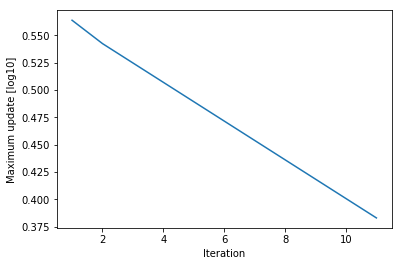

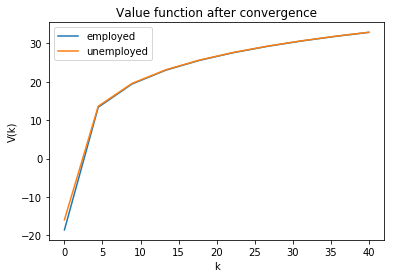

[[-1.98593642e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06]
 [-1.72327093e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06]]
[[-1.98593642e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06]
 [-1.72327093e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06]]
[[-1.98593642e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06]
 [-1.72327093e+01 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+06 -1.00001657e+06 -1.00001657e+06
  -1.00001657e+06 -1.00001657e+

[[ 4.57396488e+01  4.55974218e+01  4.54315581e+01  4.52326044e+01
   4.49839820e+01  4.46523374e+01  4.41526863e+01  4.31081471e+01
  -9.99956773e+05 -9.99956773e+05]
 [ 4.57777915e+01  4.56412680e+01  4.54831140e+01  4.52951607e+01
   4.50635096e+01  4.47614855e+01  4.43267039e+01  4.35400687e+01
  -9.99956773e+05 -9.99956773e+05]]
[[ 4.57396488e+01  4.55974218e+01  4.54315581e+01  4.52326044e+01
   4.49839820e+01  4.46523374e+01  4.41526863e+01  4.31081471e+01
  -9.99956773e+05 -9.99956773e+05]
 [ 4.57777915e+01  4.56412680e+01  4.54831140e+01  4.52951607e+01
   4.50635096e+01  4.47614855e+01  4.43267039e+01  4.35400687e+01
  -9.99956773e+05 -9.99956773e+05]]
[[ 4.57396488e+01  4.55974218e+01  4.54315581e+01  4.52326044e+01
   4.49839820e+01  4.46523374e+01  4.41526863e+01  4.31081471e+01
  -9.99956773e+05 -9.99956773e+05]
 [ 4.57777915e+01  4.56412680e+01  4.54831140e+01  4.52951607e+01
   4.50635096e+01  4.47614855e+01  4.43267039e+01  4.35400687e+01
  -9.99956773e+05 -9.99956773e+

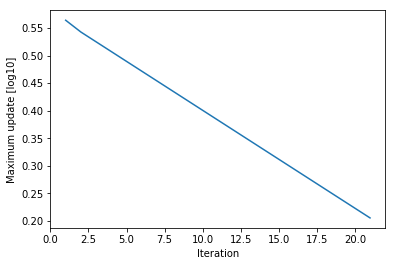

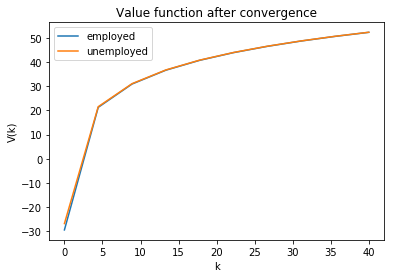

[[-3.02504967e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06]
 [-2.76238417e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06]]
[[-3.02504967e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06]
 [-2.76238417e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06]]
[[-3.02504967e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06]
 [-2.76238417e+01 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+06 -1.00002696e+06 -1.00002696e+06
  -1.00002696e+06 -1.00002696e+

  -9.99942643e+05 -9.99942643e+05]]
[[ 5.98695282e+01  5.97273012e+01  5.95614375e+01  5.93624838e+01
   5.91138614e+01  5.87822168e+01  5.82825657e+01  5.72380265e+01
  -9.99942643e+05 -9.99942643e+05]
 [ 5.99076709e+01  5.97711474e+01  5.96129934e+01  5.94250401e+01
   5.91933890e+01  5.88913648e+01  5.84565833e+01  5.76699481e+01
  -9.99942643e+05 -9.99942643e+05]]
[[ 5.98695282e+01  5.97273012e+01  5.95614375e+01  5.93624838e+01
   5.91138614e+01  5.87822168e+01  5.82825657e+01  5.72380265e+01
  -9.99942643e+05 -9.99942643e+05]
 [ 5.99076709e+01  5.97711474e+01  5.96129934e+01  5.94250401e+01
   5.91933890e+01  5.88913648e+01  5.84565833e+01  5.76699481e+01
  -9.99942643e+05 -9.99942643e+05]]
[[ 5.98695282e+01  5.97273012e+01  5.95614375e+01  5.93624838e+01
   5.91138614e+01  5.87822168e+01  5.82825657e+01  5.72380265e+01
  -9.99942643e+05 -9.99942643e+05]
 [ 5.99076709e+01  5.97711474e+01  5.96129934e+01  5.94250401e+01
   5.91933890e+01  5.88913648e+01  5.84565833e+01  5.76699481

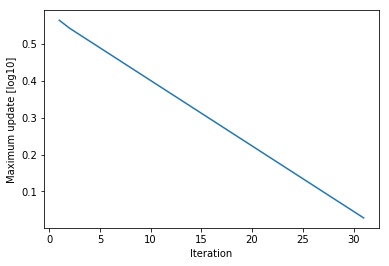

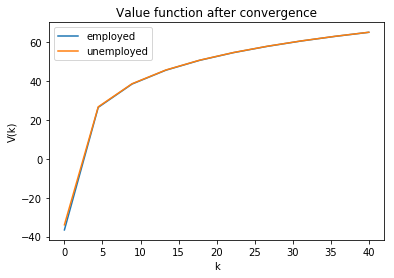

[[-3.71588607e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06]
 [-3.45322057e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06]]
[[-3.71588607e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06]
 [-3.45322057e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06]]
[[-3.71588607e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06]
 [-3.45322057e+01 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+06 -1.00003387e+06 -1.00003387e+06
  -1.00003387e+06 -1.00003387e+

  -9.99971003e+05 -9.99971003e+05]]
[[ 2.94510898e+01 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05]
 [ 2.97169656e+01  2.81268409e+01 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05]]
[[ 2.94510898e+01 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05]
 [ 2.97169656e+01  2.81268409e+01 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05]]
[[ 2.94510898e+01 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05]
 [ 2.97169656e+01  2.81268409e+01 -9.99971003e+05 -9.99971003e+05
  -9.99971003e+05 -9.99971003e+05 -9.99971003e+05 -9.99971003

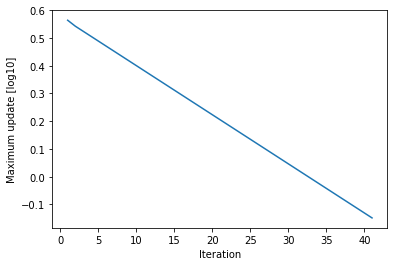

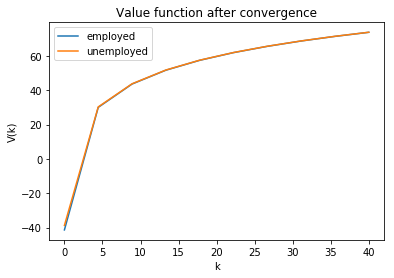

[[-4.17517665e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06]
 [-3.91251115e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06]]
[[-4.17517665e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06]
 [-3.91251115e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06]]
[[-4.17517665e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06]
 [-3.91251115e+01 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+06 -1.00003847e+06 -1.00003847e+06
  -1.00003847e+06 -1.00003847e+

  -9.99968687e+05 -9.99968687e+05]]
[[ 3.17668104e+01 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05]
 [ 3.20326862e+01  3.04425616e+01 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05]]
[[ 3.17668104e+01 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05]
 [ 3.20326862e+01  3.04425616e+01 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05]]
[[ 3.17668104e+01 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05]
 [ 3.20326862e+01  3.04425616e+01 -9.99968687e+05 -9.99968687e+05
  -9.99968687e+05 -9.99968687e+05 -9.99968687e+05 -9.99968687

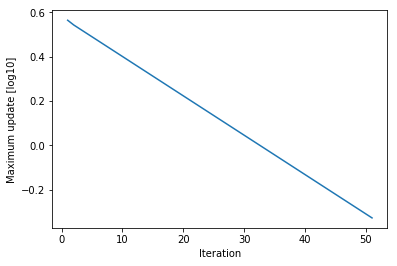

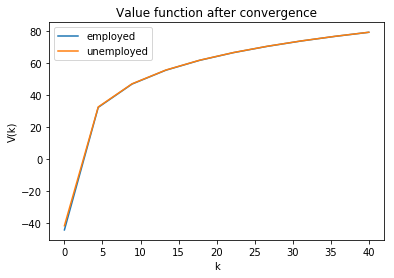

[[-4.48052802e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06]
 [-4.21786252e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06]]
[[-4.48052802e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06]
 [-4.21786252e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06]]
[[-4.48052802e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06]
 [-4.21786252e+01 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+06 -1.00004152e+06 -1.00004152e+06
  -1.00004152e+06 -1.00004152e+

  -9.99937453e+05 -9.99937453e+05]]
[[ 6.43689314e+01  6.40619304e+01  6.36166705e+01  6.27936517e+01
  -9.99937453e+05 -9.99937453e+05 -9.99937453e+05 -9.99937453e+05
  -9.99937453e+05 -9.99937453e+05]
 [ 6.44435970e+01  6.41621208e+01  6.37689531e+01  6.31118161e+01
   6.04630576e+01 -9.99937453e+05 -9.99937453e+05 -9.99937453e+05
  -9.99937453e+05 -9.99937453e+05]]
[[ 6.43689314e+01  6.40619304e+01  6.36166705e+01  6.27936517e+01
  -9.99937453e+05 -9.99937453e+05 -9.99937453e+05 -9.99937453e+05
  -9.99937453e+05 -9.99937453e+05]
 [ 6.44435970e+01  6.41621208e+01  6.37689531e+01  6.31118161e+01
   6.04630576e+01 -9.99937453e+05 -9.99937453e+05 -9.99937453e+05
  -9.99937453e+05 -9.99937453e+05]]
[[ 6.43689314e+01  6.40619304e+01  6.36166705e+01  6.27936517e+01
  -9.99937453e+05 -9.99937453e+05 -9.99937453e+05 -9.99937453e+05
  -9.99937453e+05 -9.99937453e+05]
 [ 6.44435970e+01  6.41621208e+01  6.37689531e+01  6.31118161e+01
   6.04630576e+01 -9.99937453e+05 -9.99937453e+05 -9.99937453

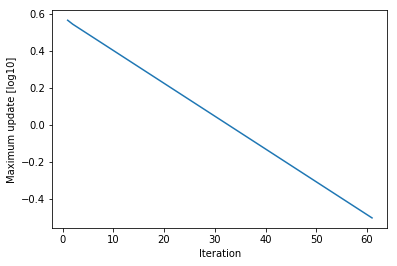

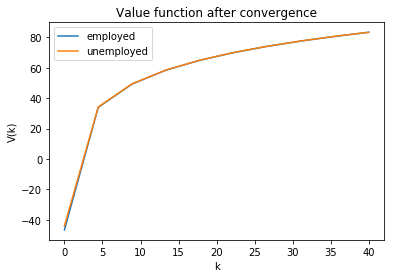

[[-4.68353558e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06]
 [-4.42087008e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06]]
[[-4.68353558e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06]
 [-4.42087008e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06]]
[[-4.68353558e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06]
 [-4.42087008e+01 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+06 -1.00004355e+06 -1.00004355e+06
  -1.00004355e+06 -1.00004355e+

  -9.99920091e+05 -9.99920091e+05]]
[[ 8.24216475e+01  8.22794205e+01  8.21135568e+01  8.19146030e+01
   8.16659807e+01  8.13343360e+01  8.08346850e+01  7.97901458e+01
  -9.99920091e+05 -9.99920091e+05]
 [ 8.24597901e+01  8.23232667e+01  8.21651127e+01  8.19771594e+01
   8.17455083e+01  8.14434841e+01  8.10087026e+01  8.02220673e+01
  -9.99920091e+05 -9.99920091e+05]]
[[ 8.24216475e+01  8.22794205e+01  8.21135568e+01  8.19146030e+01
   8.16659807e+01  8.13343360e+01  8.08346850e+01  7.97901458e+01
  -9.99920091e+05 -9.99920091e+05]
 [ 8.24597901e+01  8.23232667e+01  8.21651127e+01  8.19771594e+01
   8.17455083e+01  8.14434841e+01  8.10087026e+01  8.02220673e+01
  -9.99920091e+05 -9.99920091e+05]]
[[ 8.24216475e+01  8.22794205e+01  8.21135568e+01  8.19146030e+01
   8.16659807e+01  8.13343360e+01  8.08346850e+01  7.97901458e+01
  -9.99920091e+05 -9.99920091e+05]
 [ 8.24597901e+01  8.23232667e+01  8.21651127e+01  8.19771594e+01
   8.17455083e+01  8.14434841e+01  8.10087026e+01  8.02220673

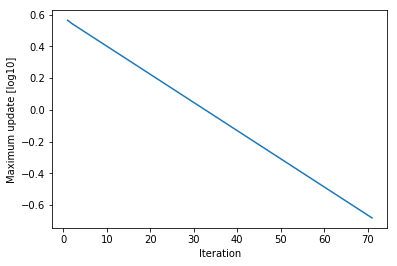

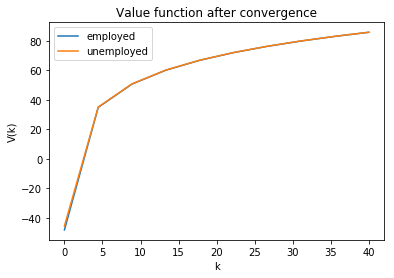

[[-4.81850163e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06]
 [-4.55583613e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06]]
[[-4.81850163e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06]
 [-4.55583613e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06]]
[[-4.81850163e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06]
 [-4.55583613e+01 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+06 -1.00004490e+06 -1.00004490e+06
  -1.00004490e+06 -1.00004490e+

  -9.99949553e+05 -9.99949553e+05]]
[[ 6.11157822e+01  6.06822907e+01  5.99000189e+01 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05]
 [ 6.12139585e+01  6.08299638e+01  6.01985933e+01  5.80767812e+01
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05]]
[[ 6.11157822e+01  6.06822907e+01  5.99000189e+01 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05]
 [ 6.12139585e+01  6.08299638e+01  6.01985933e+01  5.80767812e+01
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05]]
[[ 6.11157822e+01  6.06822907e+01  5.99000189e+01 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421e+05
  -9.99940421e+05 -9.99940421e+05]
 [ 6.12139585e+01  6.08299638e+01  6.01985933e+01  5.80767812e+01
  -9.99940421e+05 -9.99940421e+05 -9.99940421e+05 -9.99940421

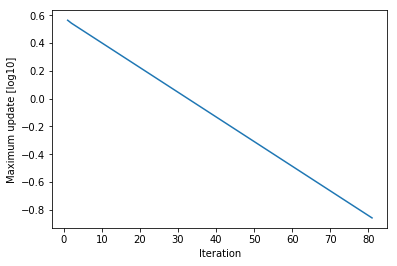

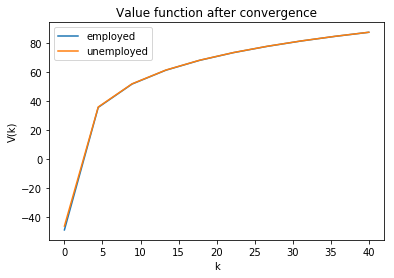

[[-4.90823146e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06]
 [-4.64556596e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06]]
[[-4.90823146e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06]
 [-4.64556596e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06]]
[[-4.90823146e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06]
 [-4.64556596e+01 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+06 -1.00004580e+06 -1.00004580e+06
  -1.00004580e+06 -1.00004580e+

[[ 8.83226895e+01  8.81972570e+01  8.80538037e+01  8.78862689e+01
   8.76849033e+01  8.74324960e+01  8.70940536e+01  8.65786157e+01
   8.54566174e+01 -9.99914307e+05]
 [ 8.83566765e+01  8.82356996e+01  8.80980469e+01  8.79383745e+01
   8.77482709e+01  8.75133397e+01  8.72056973e+01  8.67590750e+01
   8.59311985e+01 -9.99914307e+05]]
[[ 8.83226895e+01  8.81972570e+01  8.80538037e+01  8.78862689e+01
   8.76849033e+01  8.74324960e+01  8.70940536e+01  8.65786157e+01
   8.54566174e+01 -9.99914307e+05]
 [ 8.83566765e+01  8.82356996e+01  8.80980469e+01  8.79383745e+01
   8.77482709e+01  8.75133397e+01  8.72056973e+01  8.67590750e+01
   8.59311985e+01 -9.99914307e+05]]
[[-4.95247050e+01 -1.00004624e+06 -1.00004624e+06 -1.00004624e+06
  -1.00004624e+06 -1.00004624e+06 -1.00004624e+06 -1.00004624e+06
  -1.00004624e+06 -1.00004624e+06]
 [-4.68980500e+01 -1.00004624e+06 -1.00004624e+06 -1.00004624e+06
  -1.00004624e+06 -1.00004624e+06 -1.00004624e+06 -1.00004624e+06
  -1.00004624e+06 -1.00004624e+

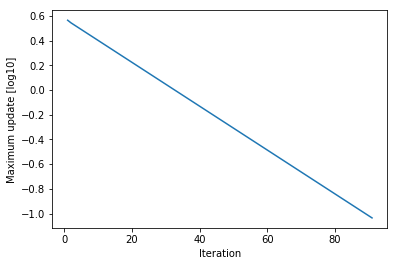

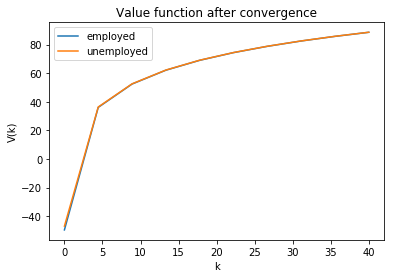

[[-4.96788678e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06]
 [-4.70522128e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06]]
[[-4.96788678e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06]
 [-4.70522128e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06]]
[[-4.96788678e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06]
 [-4.70522128e+01 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+06 -1.00004639e+06 -1.00004639e+06
  -1.00004639e+06 -1.00004639e+

  -9.99948400e+05 -9.99948400e+05]]
[[ 5.27351193e+01  5.19895748e+01 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05]
 [ 5.28784542e+01  5.22708465e+01  5.04627516e+01 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05]]
[[ 5.27351193e+01  5.19895748e+01 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05]
 [ 5.28784542e+01  5.22708465e+01  5.04627516e+01 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05]]
[[ 5.27351193e+01  5.19895748e+01 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05]
 [ 5.28784542e+01  5.22708465e+01  5.04627516e+01 -9.99948400e+05
  -9.99948400e+05 -9.99948400e+05 -9.99948400e+05 -9.99948400

(array([[-50.00855128,  36.35836239,  52.81223427,  62.57274795,
          69.53856972,  74.95931263,  79.39762498,  83.15561293,
          86.41441117,  89.29123409],
        [-47.3818963 ,  36.62423822,  52.95556912,  62.67092424,
          69.61323535,  75.01955515,  79.44811547,  83.19906923,
          86.45255379,  89.32522103]]),
 array([[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
         0.001],
        [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
         0.001]]))

In [142]:
def income_employed(w, r, k, *params):
    # unpack params:
    α, β, δ, u = params
    
    income = r + w + (1 - δ) * k
    
    return income

def income_unemployed(w, r, k, *params):
    # unpack params:
    α, β, δ, u = params
    
    income = r + (1 - δ) * k
    
    return income

def actionvalues_allchoices(V_old, P_old, k_index, T, kbar, *params):
    '''
    P: employment probability matrix
    T: transition matrix
    '''

    # unpack params:
    α, β, δ, u = params
    k = k_grid[k_index]
    action_value = np.zeros_like(V_old)
    c = np.zeros_like(V_old)
    
    # get w, r, c:
    w = get_w(kbar, *params)
    r = get_r(kbar, *params)
    c = get_c(w, r, k, np.transpose(k_grid.reshape((len(V_old[0]),1))), ϵ.reshape((2,1)), *params)
#     c[0] = income_employed(w, r, k, *params) - k_grid
#     c[1] = income_unemployed(w, r, k, *params) - k_grid
    
    # mask action values
    action_value[c <= 0] = -999999
    action_value[c > 0] = np.log(c[c > 0])

    # expected value last period
    EV = np.dot(P_old, V_old[:, k_index])

    # value function
    action_value = action_value + β * EV
    print(action_value)

    return action_value

def vf_pf_update(V_old, P_old, k_index, T, kbar, *params):
    
#     print(actionvalues_allchoices(V_old, P_old, k_index, ϵ_index, T, kbar, *params))
    Vi_old = np.max(actionvalues_allchoices(V_old, P_old, k_index, T, kbar, *params), axis = 1)
    Poli = k_grid[np.argmax(actionvalues_allchoices(V_old, P_old, k_index, T, kbar, *params), axis = 1)]

    return Vi_old, Poli

def vf_pf_iteration(V_old, P_old, T, kbar, *params):
    
    V_new = np.zeros_like(V_old)
    Pol = np.zeros_like(V_old)
    
    for k_index in range(len(k_grid)):
        V_new[:, k_index] = vf_pf_update(V_old, P_old, k_index, T, kbar, *params)[0]
        Pol[:, k_index] = vf_pf_update(V_old, P_old, k_index, T, kbar, *params)[1]

    return V_new, Pol

def iteration2converge(initial_V, initial_P, k_grid, ϵ, T, kbar, tol, maxiter, *params, plot = True):
    
    difference_list = []
    V_old = initial_V.copy()
    P_old = initial_P.copy()
    
    for i in range(maxiter):
        V_new = vf_pf_iteration(V_old, P_old, T, kbar, *params)[0]
        Pol = vf_pf_iteration(V_old, P_old, T, kbar, *params)[1]
        
        # stop:
        diff = np.max(np.abs(V_new - V_old))
#         print(diff)
        difference_list.append(diff)
        
        V_old = V_new.copy()
        P_old = np.dot(P_old, T)
        
        if plot == True:
            if i % 10 == 0:
                print('iteration: {}'.format(i))
                plt.figure()
                plt.plot(np.arange(1, i+2), np.log10(np.array(difference_list)))
                plt.xlabel('Iteration')
                plt.ylabel('Maximum update [log10]')
                plt.show()

                plt.figure()
                plt.plot(k_grid, V_new[0], label = 'employed')
                plt.plot(k_grid, V_new[1], label = 'unemployed')
                plt.xlabel('k')
                plt.ylabel('V(k)')
                plt.title('Value function after convergence')
                plt.legend()
                plt.show()
                
        if diff < tol:
            break
    
    return V_new, Pol
        
k_grid = np.linspace(0.001, 40, 10)
ϵ = np.array([0, 1])
V_init = np.zeros((2, 10))
P_init = np.array([0.9, 0.1])
T = np.array([[0.9, 0.1], [0.9, 0.1]])
kbar, rbar = solve_SS(*params1())
tol = 1e-6
maxiter = 100

iteration2converge(V_init, P_init, k_grid, ϵ, T, kbar, tol, maxiter, *params1(), plot = True)